In [20]:
from typing import Any, Callable, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Conditional GAN

In [21]:
def build_disc(
    base_filters: int=32,
    drop_rate: float=0.2,
    input_dim: int=28,
    kernel_size: int=3,
    num_blocks: int=2,
    output_activation: str="linear"
) -> Dict[str, Any]:
  """Build discriminator."""

  # Image input.
  input = tf.keras.layers.Input(
      shape=(input_dim, input_dim, 1), name="img_input")
  h = input

  # Label input.
  linput = tf.keras.layers.Input(shape=(10, ), name="lab_input")
  h2 = tf.keras.layers.Dense(10, name="lab_proj")(linput)

  # Convolutional blocks.
  for i in range(num_blocks):
    h = tf.keras.layers.Conv2D(
        base_filters * (2 ** i),
        kernel_size,
        padding="same",
        name=f"conv{i}"
      )(h)
    width = tf.keras.backend.int_shape(h)[1]
    h = tf.keras.layers.Dropout(rate=drop_rate, name=f"drop{i}")(h)
    if (width % 2 == 0):
      h = tf.keras.layers.MaxPool2D(name=f"pool{i}")(h)
    else:
      h = tf.keras.layers.MaxPool2D(pool_size=1, name=f"pool{i}")(h)
    h = tf.keras.layers.ELU(name=f"elu{i}")(h)

  # Output layer.
  last_conv_shape = tf.keras.backend.int_shape(h)
  h = tf.keras.layers.Flatten(name="flat")(h)
  h = tf.keras.layers.Concatenate(axis=1)([h, h2])
  output = tf.keras.layers.Dense(1, activation=output_activation)(h)

  # Build model.
  model = tf.keras.Model([input, linput], output, name="discriminator")

  # Output.
  return {
    "model": model,
    "input_shape": tf.keras.backend.int_shape(input),
    "last_conv_shape": last_conv_shape[1:],
  }

The conditional input will be a 1-hot encoded vector of length 10. That vector is extended to the same length as the noise input vector by concatenating replicates of the conditional input then zero padding.

In [22]:
def _format_cinput(x: tf.Tensor, input_dim: int=128) -> tf.Tensor:
  reps = input_dim // 10
  pad = input_dim % 10
  rep_vec = tf.tile(x, [1, reps])
  pad_vec = tf.zeros(shape=(tf.shape(x)[0], pad))
  out = tf.keras.layers.Concatenate(axis=1)([rep_vec, pad_vec])
  return out

In [23]:
def build_gen(
    base_filters: int=128,
    input_dim: int=128,
    kernel_size: int=4,
    num_blocks: int=3,
    output_dim: int=28,
) -> Dict[str, Any]:
  """Build generator."""

  # Noise input.
  input = tf.keras.layers.Input(shape=(input_dim, ), name="noise_input")
  h0 = tf.keras.layers.Reshape(
      (1, 1, input_dim), name="reshape1")(input)

  # Conditioning input.
  cinput = tf.keras.layers.Input(shape=(10, ), name="conditional_input")
  h1 = tf.keras.layers.Dense(10, name="cond_proj")(cinput)
  h1 = tf.keras.layers.Lambda(_format_cinput)(h1)

  # Combine noise and conditioning inputs.
  h = tf.keras.layers.Add()([h0, h1])

  # Convolutional blocks.
  for i in range(num_blocks):
    h = tf.keras.layers.Conv2DTranspose(
        base_filters // (2 ** i),
        kernel_size,
        strides=2,
        padding="same",
        name=f"conv{i}",
        use_bias=False
    )(h)
    h = tf.keras.layers.BatchNormalization(name=f"batch{i}")(h)
    h = tf.keras.layers.ELU(name=f"elu{i}")(h)

  last_conv_shape = tf.keras.backend.int_shape(h)

  # Convert to output shape.
  h = tf.keras.layers.Flatten(name="flat")(h)
  target_shape = output_dim * output_dim
  h = tf.keras.layers.Dense(target_shape, activation="tanh")(h)
  output = tf.keras.layers.Reshape(
      (output_dim, output_dim, 1), name="reshape2")(h)

  # Build model.
  model = tf.keras.Model([input, cinput], output, name="generator")

  # Output.
  return {
    "model": model,
    "input_shape": tf.keras.backend.int_shape(input),
    "last_conv_shape": last_conv_shape[1:],
  }

## WGAN

* Original paper: [Arjovsky 2017](https://arxiv.org/abs/1701.07875)
* [Code example](https://keras.io/examples/generative/wgan_gp/)

In [24]:
class WGAN(tf.keras.Model):

  def __init__(
      self,
      disc: tf.keras.Model,
      gen: tf.keras.Model,
      d_steps: int=5,
      gp_weight: float=10.0,
      latent_dim: int=128,
  ):
    """Wasserstein GAN.

    Args:
      disc: Discriminator model.
      gen: Generator model.
      d_steps: Discriminator steps per generator step.
      gp_weight: Gradient penalty weight.
      latent_dim: Latent dimension from which to generate.
    """
    super(WGAN, self).__init__()
    self.disc = disc
    self.gen = gen
    self.d_steps = d_steps
    self.gp_weight = gp_weight
    self.latent_dim = latent_dim

  def disc_loss_fn(self, real_logits, fake_logits):
    return tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)

  def gen_loss_fn(self, fake_logits):
    return -tf.reduce_mean(fake_logits)

  def compile(
      self,
      disc_opt: tf.keras.optimizers.Optimizer,
      gen_opt: tf.keras.optimizers.Optimizer,
  ):
    super(WGAN, self).compile()
    self.disc_opt = disc_opt
    self.gen_opt = gen_opt

    # Loss trackers.
    self.disc_loss = tf.keras.metrics.Mean(name="disc_loss")
    self.gen_loss = tf.keras.metrics.Mean(name="gen_loss")

  def grad_penalty(self, real_images, fake_images, labels):
    batch_size = tf.shape(real_images)[0]
    alpha = tf.random.uniform(
        shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0)
    interpol = real_images + alpha * (fake_images - real_images)

    with tf.GradientTape() as tape:
      tape.watch(interpol)
      pred = self.disc([interpol, labels], training=True)

    grads = tape.gradient(pred, [interpol])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    return tf.reduce_mean(tf.square(norm - 1.0))

  @property
  def metrics(self):
    return [self.disc_loss, self.gen_loss]

  def train_step(self, data):

    # Unpack input.
    real_images, labels = data
    batch_size = tf.shape(real_images)[0]

    # Train the descriminator.
    for i in range(self.d_steps):
      random_draws = tf.random.normal(shape=(batch_size, self.latent_dim))

      with tf.GradientTape() as d_tape:
        fake_images = self.gen([random_draws, labels], training=True)
        real_logits = self.disc([real_images, labels], training=True)
        fake_logits = self.disc([fake_images, labels], training=True)

        d_loss = self.disc_loss_fn(real_logits, fake_logits)
        gp = self.grad_penalty(real_images, fake_images, labels)
        d_loss += self.gp_weight * gp

      # Update discriminator.
      disc_grads = d_tape.gradient(d_loss, self.disc.trainable_variables)
      self.disc_opt.apply_gradients(
          zip(disc_grads, self.disc.trainable_variables))

    # Train the generator.
    random_draws = tf.random.normal(shape=(batch_size, self.latent_dim))

    with tf.GradientTape() as g_tape:
      fake_images = self.gen([random_draws, labels], training=True)
      fake_logits = self.disc([fake_images, labels], training=True)
      g_loss = self.gen_loss_fn(fake_logits)

    # Update generator.
    gen_grads = g_tape.gradient(g_loss, self.gen.trainable_variables)
    self.gen_opt.apply_gradients(zip(gen_grads, self.gen.trainable_variables))

    # Update metrics.
    self.disc_loss.update_state(d_loss)
    self.gen_loss.update_state(g_loss)

    return {m.name: m.result() for m in self.metrics}

  def plot_images(self):
    z_dim = 128
    noise = tf.random.normal((10, z_dim))
    labels = tf.keras.utils.to_categorical(
        tf.constant([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 10)
    imgs = self.gen([noise, labels])
    imgs = imgs.numpy()

    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()

    for i in range(10):
      axes[i].imshow(imgs[i, :].squeeze(), cmap="gray")
      axes[i].axis("off")

    plt.tight_layout()
    plt.show()

    return None

## Visualize

In [25]:
class PlotCallback(tf.keras.callbacks.Callback):
    def __init__(self, plot_every: int=2):
        super(PlotCallback, self).__init__()
        self.plot_every = plot_every
        self.epoch_count = 0

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_count += 1
        if self.epoch_count == 1 or (self.epoch_count % self.plot_every == 0):
          self.model.plot_images()

## Example

### Data

In [26]:
def prepare_mnist_data(
  val_frac: float=0.2,
  seed: int=101,
) -> Dict[str, Any]:

  # Load data.
  (x_train, y_train), (x_test, y_test) = \
    tf.keras.datasets.mnist.load_data()

  # Standardize.
  x_train = (x_train.astype("float32") - 127.5) / 255.0
  x_test  = (x_test.astype("float32") - 127.5) / 255.0

  # Add channel axis.
  x_train = np.expand_dims(x_train, axis=-1)
  x_test = np.expand_dims(x_test, axis=-1)

  # Convert labels to categorical.
  y_train = tf.keras.utils.to_categorical(y_train, 10)
  y_test = tf.keras.utils.to_categorical(y_test, 10)

  # Output.
  return {
    "x_train": x_train,
    "y_train": y_train,
    "x_test": x_test,
    "y_test": y_test,
  }


In [27]:
data = prepare_mnist_data(val_frac=0.0)

### Generator

In [10]:
input = tf.random.normal((1, 128))
cinput = tf.expand_dims(tf.constant([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), axis=0)

In [11]:
gen_model = build_gen()["model"]

In [12]:
# Test call of generative model.
out = gen_model([input, cinput])
out.shape

TensorShape([1, 28, 28, 1])

### Discriminator

In [13]:
input = tf.random.normal((1, 128))
linput = tf.expand_dims(tf.constant([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), axis=0)

In [14]:
disc_model = build_disc()["model"]

In [15]:
# Test call of discriminator model.
out = gen_model([input, linput])
out.shape

TensorShape([1, 28, 28, 1])

### Training

In [28]:
# Specify model.
disc = build_disc()["model"]
gen = build_gen()["model"]
gan = WGAN(disc, gen)

In [29]:
# Optimizers.
disc_opt = tf.keras.optimizers.AdamW()
gen_opt = tf.keras.optimizers.AdamW()
gan.compile(disc_opt, gen_opt)

In [30]:
# Plot callback
plot_cbk = PlotCallback()

Epoch 1/20
938/938 [==============================] - ETA: 0s - disc_loss: -4.4712 - gen_loss: 3.5873

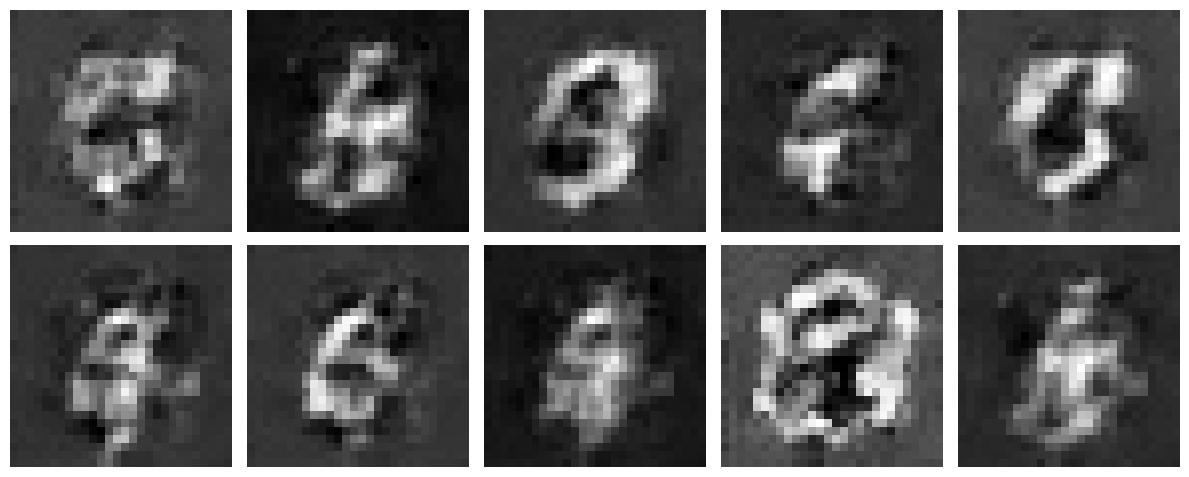

938/938 [==============================] - 65s 58ms/step - disc_loss: -4.4712 - gen_loss: 3.5873
Epoch 2/20
938/938 [==============================] - ETA: 0s - disc_loss: -2.9774 - gen_loss: -7.5198

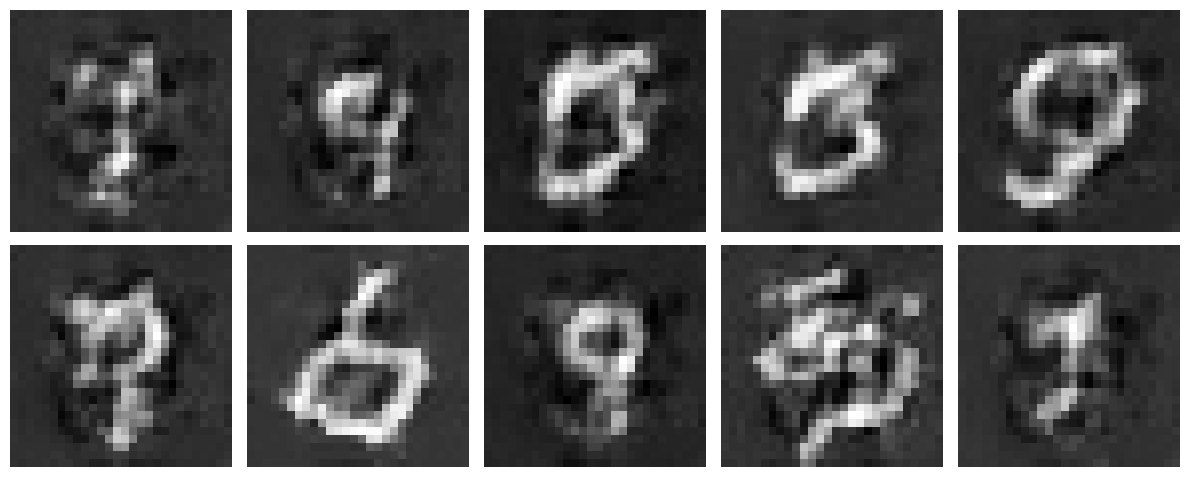

938/938 [==============================] - 58s 62ms/step - disc_loss: -2.9774 - gen_loss: -7.5198
Epoch 3/20
938/938 [==============================] - 54s 57ms/step - disc_loss: -2.5248 - gen_loss: -1.6211
Epoch 4/20
937/938 [============================>.] - ETA: 0s - disc_loss: -2.3570 - gen_loss: -2.5854

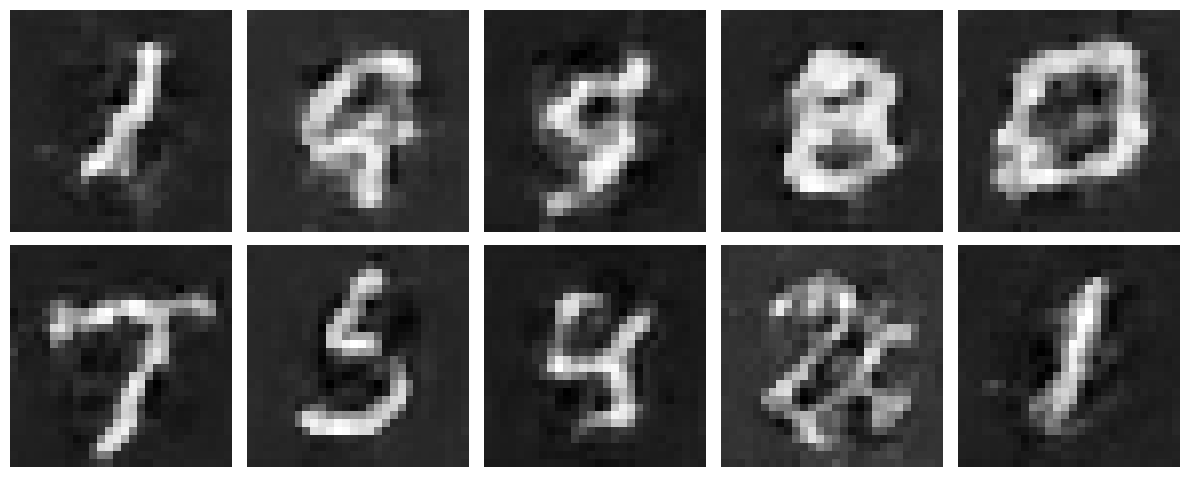

938/938 [==============================] - 54s 58ms/step - disc_loss: -2.3572 - gen_loss: -2.5855
Epoch 5/20
938/938 [==============================] - 52s 55ms/step - disc_loss: -2.2944 - gen_loss: -3.9383
Epoch 6/20
938/938 [==============================] - ETA: 0s - disc_loss: -2.3005 - gen_loss: -4.9471

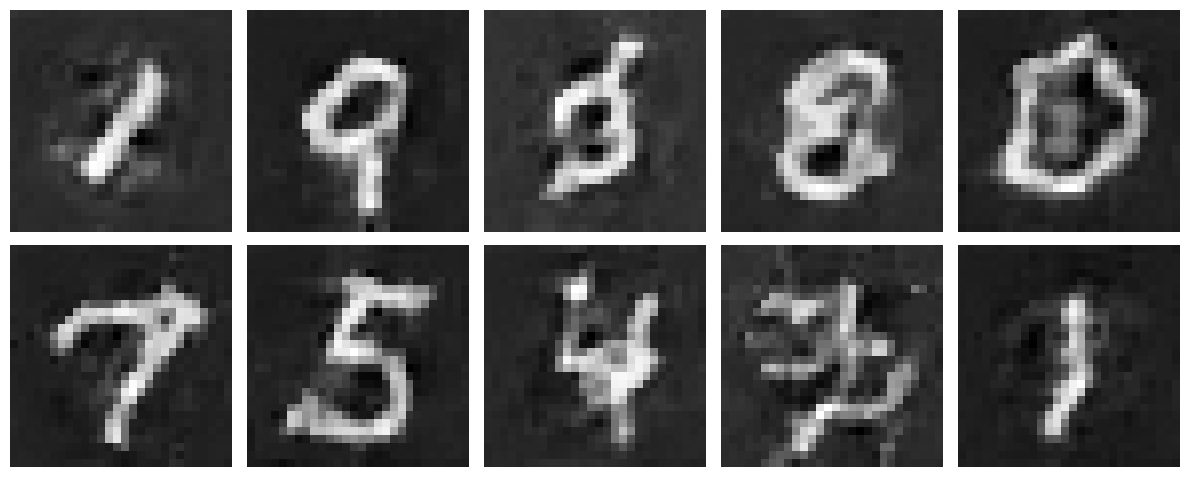

938/938 [==============================] - 53s 56ms/step - disc_loss: -2.3005 - gen_loss: -4.9471
Epoch 7/20
938/938 [==============================] - 52s 55ms/step - disc_loss: -2.1973 - gen_loss: -2.9091
Epoch 8/20
937/938 [============================>.] - ETA: 0s - disc_loss: -2.0392 - gen_loss: -1.6701

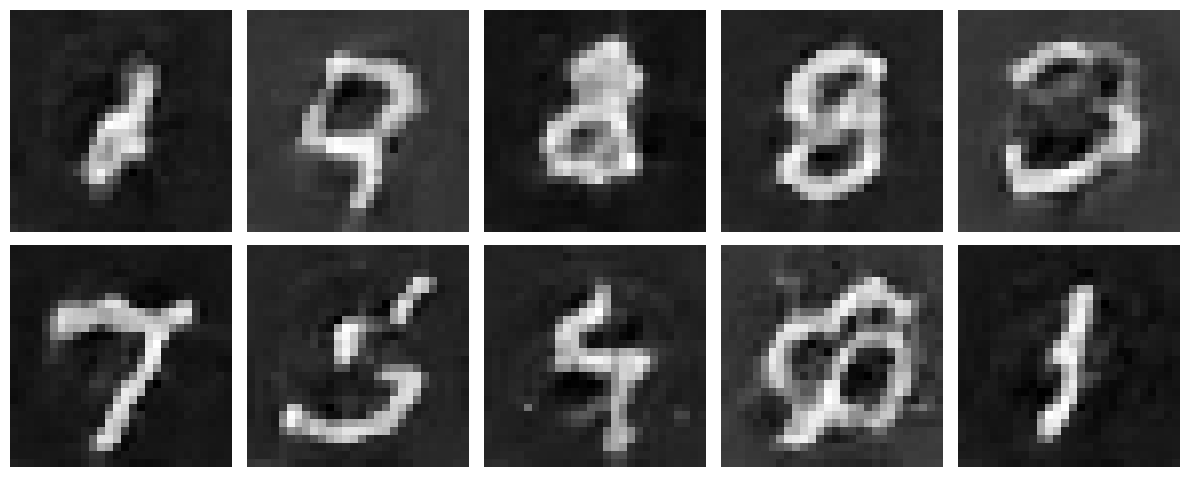

938/938 [==============================] - 52s 56ms/step - disc_loss: -2.0395 - gen_loss: -1.6674
Epoch 9/20
938/938 [==============================] - 52s 55ms/step - disc_loss: -1.9694 - gen_loss: -0.2759
Epoch 10/20
937/938 [============================>.] - ETA: 0s - disc_loss: -1.9304 - gen_loss: -0.6675

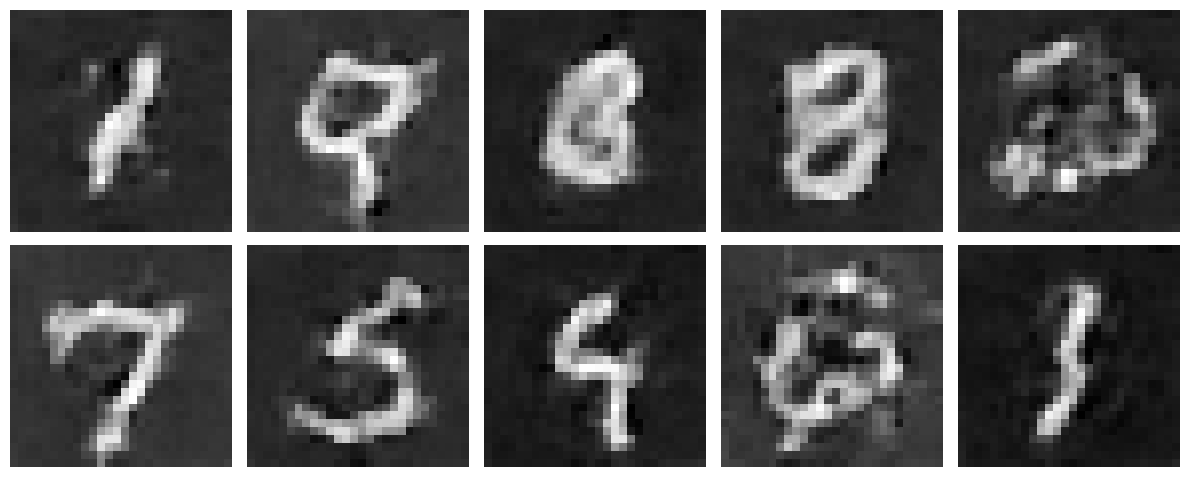

938/938 [==============================] - 52s 55ms/step - disc_loss: -1.9303 - gen_loss: -0.6652
Epoch 11/20
938/938 [==============================] - 52s 55ms/step - disc_loss: -1.8858 - gen_loss: 1.9953
Epoch 12/20
937/938 [============================>.] - ETA: 0s - disc_loss: -1.8139 - gen_loss: 0.8496

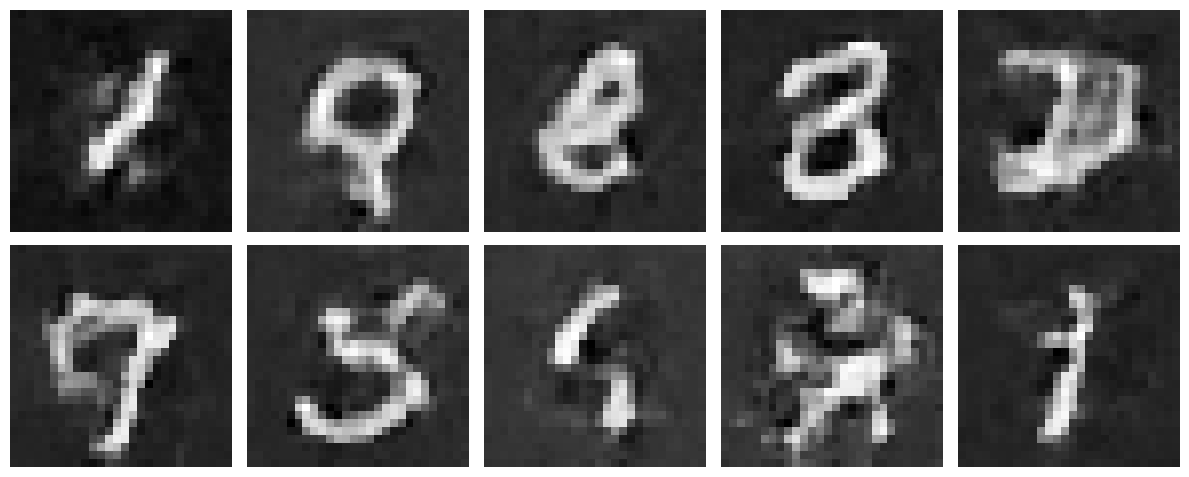

938/938 [==============================] - 52s 56ms/step - disc_loss: -1.8143 - gen_loss: 0.8540
Epoch 13/20
938/938 [==============================] - 52s 55ms/step - disc_loss: -1.7965 - gen_loss: 4.5653
Epoch 14/20
937/938 [============================>.] - ETA: 0s - disc_loss: -1.8648 - gen_loss: 3.6606

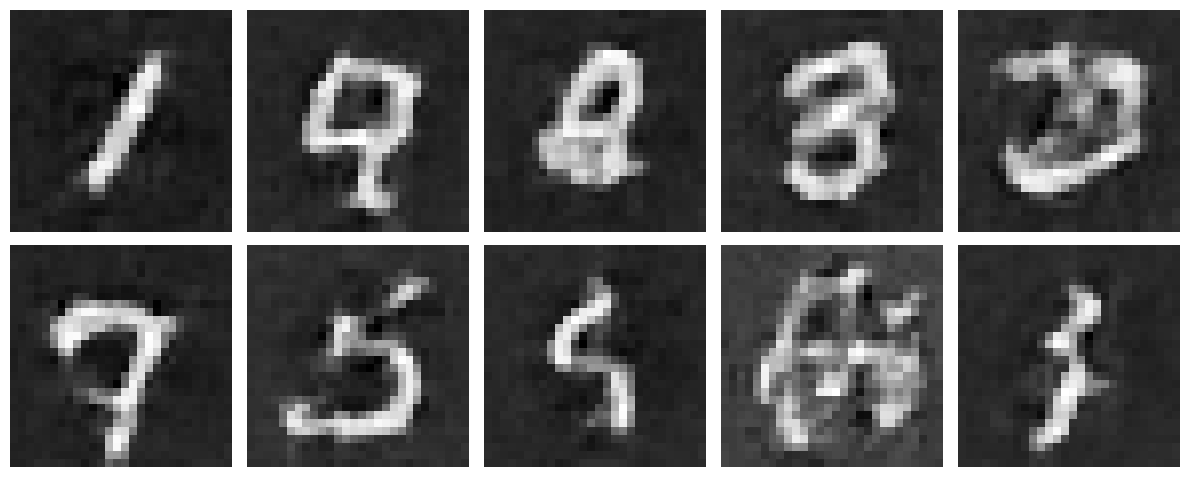

938/938 [==============================] - 53s 56ms/step - disc_loss: -1.8653 - gen_loss: 3.6645
Epoch 15/20
938/938 [==============================] - 52s 56ms/step - disc_loss: -1.8248 - gen_loss: 1.3014
Epoch 16/20
937/938 [============================>.] - ETA: 0s - disc_loss: -1.8652 - gen_loss: 0.9116

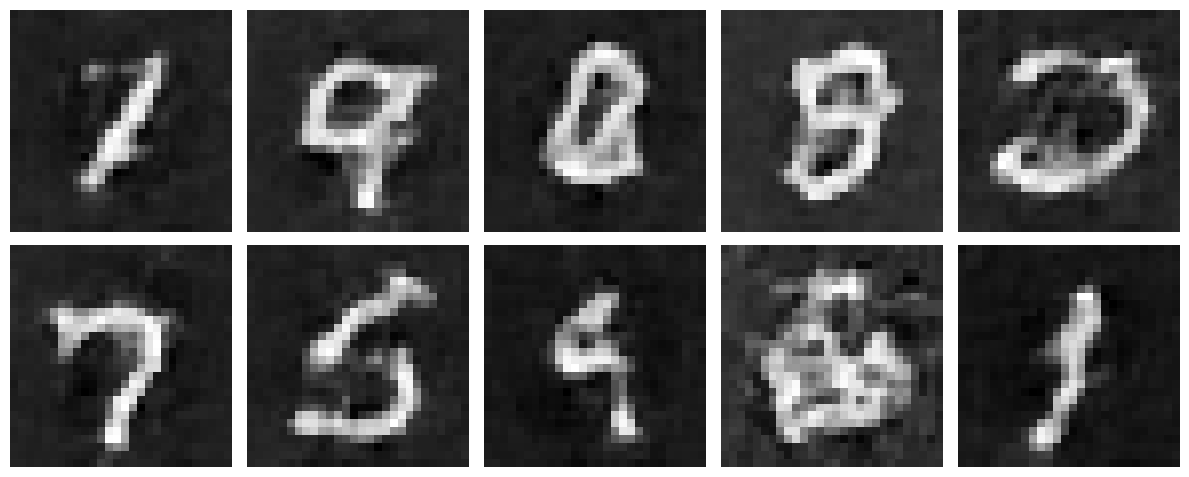

938/938 [==============================] - 53s 56ms/step - disc_loss: -1.8652 - gen_loss: 0.9118
Epoch 17/20
938/938 [==============================] - 52s 56ms/step - disc_loss: -1.8403 - gen_loss: -1.3726
Epoch 18/20
937/938 [============================>.] - ETA: 0s - disc_loss: -1.8817 - gen_loss: -2.1791

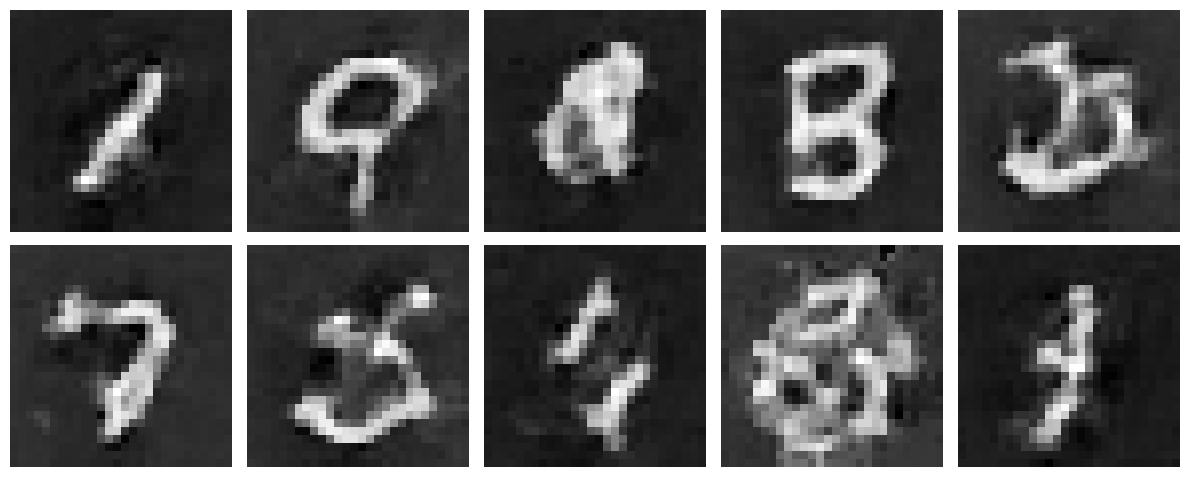

938/938 [==============================] - 53s 56ms/step - disc_loss: -1.8821 - gen_loss: -2.1804
Epoch 19/20
938/938 [==============================] - 53s 56ms/step - disc_loss: -1.8491 - gen_loss: -1.6427
Epoch 20/20
937/938 [============================>.] - ETA: 0s - disc_loss: -1.8823 - gen_loss: -0.7560

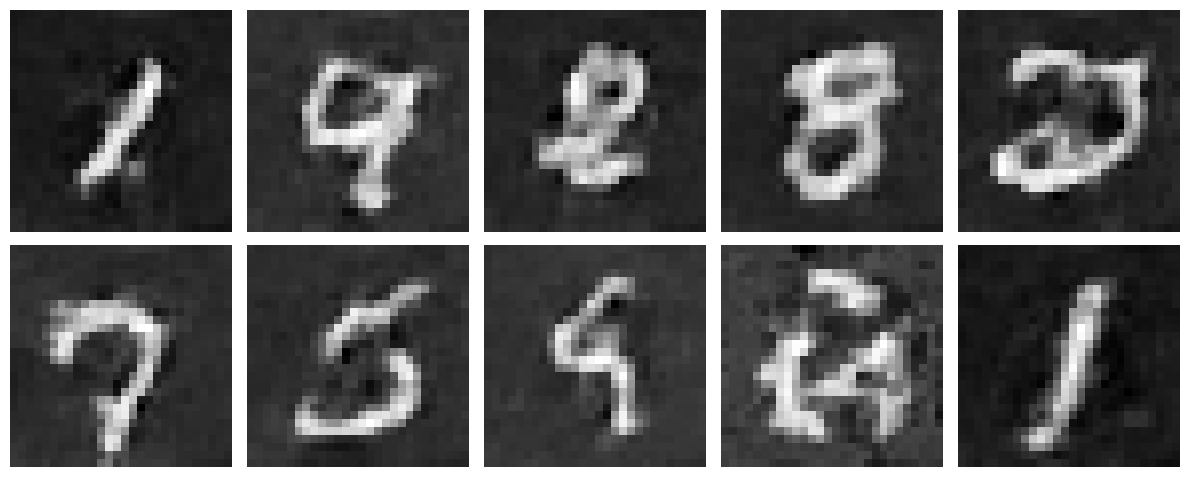

938/938 [==============================] - 53s 57ms/step - disc_loss: -1.8823 - gen_loss: -0.7567


In [31]:
# Fit.
history = gan.fit(
  x=data["x_train"],
  y=data["y_train"],
  batch_size=64,
  epochs=20,
  callbacks=[plot_cbk]
)